## Trading Strategy Optimization - Nifty50

As a Risk Quant, my responsibility is to develop and refine trading strategies aimed at minimizing drawdowns and optimizing the Sharpe ratio to achieve better risk-adjusted returns. However, due to my limited experience in the financial markets and stock trading, I sometimes find it challenging to determine which strategy would be best suited to maximize returns. My primary objective is always to outperform the market.

To assess this, I examined the performance of Nifty50 returns over a four-year period (2020-2024) using two different strategies: 
1. The Mean Reversion Strategy
2. The EMA Crossover Strategy


In [132]:
nifty_data = nifty_data.reset_index(drop=True)


# Mean Reversion Strategy

In [133]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download NIFTY50 data
nifty_data = yf.download("^NSEI", start="2020-01-01", end="2024-01-01")

# Flatten MultiIndex columns (if present)
if isinstance(nifty_data.columns, pd.MultiIndex):
    nifty_data.columns = ['_'.join(col).strip() for col in nifty_data.columns]

# Compute Bollinger Bands
nifty_data['SMA_20'] = nifty_data['Close_^NSEI'].rolling(window=20).mean()
nifty_data['Std_Dev'] = nifty_data['Close_^NSEI'].rolling(window=20).std()
nifty_data['Upper Band'] = nifty_data['SMA_20'] + (2 * nifty_data['Std_Dev'])
nifty_data['Lower Band'] = nifty_data['SMA_20'] - (2 * nifty_data['Std_Dev'])

# Drop NaN values before proceeding
nifty_data.dropna(subset=['Close_^NSEI', 'Lower Band', 'Upper Band'], inplace=True)

# Ensure Index Consistency
nifty_data = nifty_data.reset_index(drop=True)

# Initialize Signal Column
nifty_data['Signal'] = 0

# Use .loc[] to avoid chained assignment error
nifty_data.loc[nifty_data['Close_^NSEI'] < nifty_data['Lower Band'], 'Signal'] = 1  # Buy Signal
nifty_data.loc[nifty_data['Close_^NSEI'] > nifty_data['Upper Band'], 'Signal'] = -1  # Sell Signal

# Shift signals to create positions (Avoid Look-ahead Bias)
nifty_data['Position'] = nifty_data['Signal'].shift()
nifty_data['Position'].dropna()


[*********************100%***********************]  1 of 1 completed


1      0.0
2      0.0
3      0.0
4      0.0
5      1.0
      ... 
967    0.0
968    0.0
969    0.0
970    0.0
971    0.0
Name: Position, Length: 971, dtype: float64

## Calculating the Market and Strategy Returns

In [134]:
# Returns
nifty_data['Market Return'] = nifty_data['Close_^NSEI'].pct_change()
nifty_data['Strategy Return'] = nifty_data['Position'] * nifty_data['Market Return']
nifty_data[['Market Return','Strategy Return']].dropna()

,Market Return,Strategy Return
1,0.006113,0.000000
2,-0.007725,-0.000000
3,-0.006123,-0.000000
4,-0.021250,-0.000000
5,0.023211,0.023211
...,...,...
967,0.004439,0.000000
968,0.004307,0.000000
969,0.009953,0.000000
970,0.005724,0.000000


# Cumulative Market and Strategy Returns

In [135]:
# Cumulative Returns
nifty_data['Cumulative Market Return'] = (1 + nifty_data['Market Return']).cumprod()
nifty_data['Cumulative Strategy Return'] = (1 + nifty_data['Strategy Return']).cumprod()
nifty_data[['Cumulative Strategy Return','Cumulative Market Return']].dropna()


,Cumulative Strategy Return,Cumulative Market Return
1,1.000000,1.006113
2,1.000000,0.998341
3,1.000000,0.992228
4,1.000000,0.971143
5,1.023211,0.993684
...,...,...
967,0.810502,1.770882
968,0.810502,1.778509
969,0.810502,1.796210
970,0.810502,1.806491


## Plotting the performance of our strategy against the market return

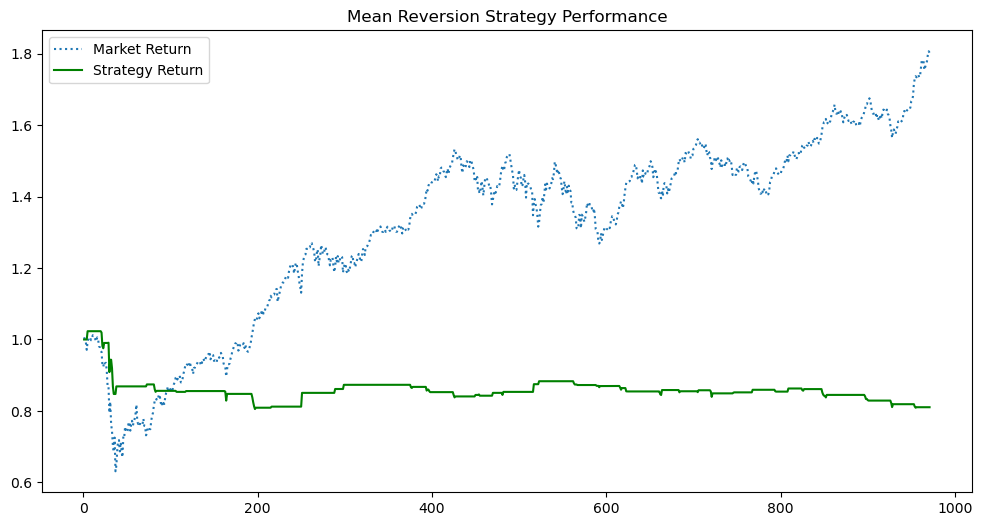

In [136]:
# Plot Performance
plt.figure(figsize=(12, 6))
plt.plot(nifty_data['Cumulative Market Return'], label="Market Return", linestyle='dotted')
plt.plot(nifty_data['Cumulative Strategy Return'], label="Strategy Return", color='g')
plt.legend()
plt.title("Mean Reversion Strategy Performance")
plt.show()


From a visual inspection of the results, it is evident that the Mean Reversion Strategy failed to outperform the market returns.


## Sharpe Ratio 

In [137]:
# Sharpe Ratio Calculation
sharpe_ratio = (nifty_data['Strategy Return'].mean() / nifty_data['Strategy Return'].std()) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: -0.65


Poor Sharpe ratio indicates poor risk adjusted retrun i.e for 1 unit of risk our strategy only yields us -65% returns so we are losing money in real terms 

## Drawdown Score

In [138]:
# Maximum Drawdown Calculation
rolling_max = nifty_data['Cumulative Strategy Return'].cummax()
drawdown = (nifty_data['Cumulative Strategy Return'] / rolling_max) - 1
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown:.2%}")


Max Drawdown: -21.29%


Max drawdown is important in understanding the worst-case scenario for your strategy. The maximum drawdown is -21.29%, meaning at one point, the strategy lost 21.29% of its value from the peak to the trough.

### Improving the Mean Reversion Strategy

In an effort to improve the performance of my Mean Reversion trading strategy, I decided to enhance several key components:

1. **Optimized Bollinger Bands**: I made the Bollinger Bands dynamic, allowing the strategy to adapt to changing market conditions. This was aimed at improving entry and exit points, making the strategy more responsive to volatility.

2. **Incorporated Additional Technical Indicators**: I introduced the Relative Strength Index (RSI) to help identify overbought or oversold conditions, which is crucial for mean reversion strategies. This addition aids in determining more accurate buy and sell signals.

3. **Kelly Criterion for Position Sizing**: To optimize the capital used for each trade, I implemented the Kelly Criterion. This allowed me to calculate the optimal amount of capital to allocate based on expected returns and risk, helping to maximize long-term growth while managing risk.

4. **ATR-Based Stop Loss**: To manage risk more dynamically, I incorporated an Average True Range (ATR) based stop-loss. This adjusts the stop-loss level based on the market's volatility, providing more flexibility and better risk control.

By combining these elements, I aimed to enhance the strategy's returns, making it more competitive and potentially outperforming the market.


In [139]:
pip install ta


In [140]:
nifty_data_n = yf.download("^NSEI", start="2020-01-01", end="2024-01-01")

# Flatten MultiIndex columns (if present)
if isinstance(nifty_data_n.columns, pd.MultiIndex):
    nifty_data_n.columns = ['_'.join(col).strip() for col in nifty_data_n.columns]


[*********************100%***********************]  1 of 1 completed


In [141]:
nifty_data_n.columns

Index(['Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI'], dtype='object')

## Generating Trading Signals

In [142]:
nifty_data_n['SMA200'] = nifty_data_n['Close_^NSEI'].rolling(window=200).mean()
nifty_data_n['ADX'] = ta.trend.ADXIndicator(nifty_data_n['High_^NSEI'], nifty_data_n['Low_^NSEI'], nifty_data_n['Close_^NSEI'], window=14).adx()

# Condition: Only trade mean reversion when price is below SMA200 & ADX < 25 (weak trend)
nifty_data_n['Trade Signal'] = (nifty_data_n['Close_^NSEI'] < nifty_data_n['SMA200']) & (nifty_data_n['ADX'] < 25)
nifty_data_n['Trade Signal']


Date
2020-01-01    False
2020-01-02    False
2020-01-03    False
2020-01-06    False
2020-01-07    False
              ...  
2023-12-22    False
2023-12-26    False
2023-12-27    False
2023-12-28    False
2023-12-29    False
Name: Trade Signal, Length: 991, dtype: bool

## Optimising Bollinger Band and Generating Buy and Sell Signals

In [143]:
#Optimize Bollinger Bands for Better Entries

nifty_data_n['Rolling Mean'] = nifty_data_n['Close_^NSEI'].rolling(window=20).mean()
nifty_data_n['Rolling Std'] =nifty_data_n['Close_^NSEI'].rolling(window=20).std()

# Dynamic Bollinger Bands
nifty_data_n['Upper Band'] = nifty_data_n['Rolling Mean'] + (2.5 * nifty_data_n['Rolling Std'])
nifty_data_n['Lower Band'] = nifty_data_n['Rolling Mean'] - (2.5 * nifty_data_n['Rolling Std'])

# Buy when price crosses below Lower Band, Sell when above Upper Band
nifty_data_n['Buy Signal'] = nifty_data_n['Close_^NSEI'] < nifty_data_n['Lower Band'] #Over sold
nifty_data_n['Sell Signal'] = nifty_data_n['Close_^NSEI'] > nifty_data_n['Upper Band'] #Over Bought
nifty_data_n[['Buy Signal','Sell Signal']]
# Initialize Signal Column
nifty_data_n['Signal'] = 0

# Use .loc[] to avoid chained assignment error
nifty_data_n.loc[nifty_data_n['Close_^NSEI'] < nifty_data_n['Lower Band'], 'Signal'] = 1  # Buy Signal
nifty_data_n.loc[nifty_data_n['Close_^NSEI'] > nifty_data_n['Upper Band'], 'Signal'] = -1  # Sell Signal

# Shift signals to create positions (Avoid Look-ahead Bias)
nifty_data_n['Position_n'] = nifty_data_n['Signal'].shift()
nifty_data_n['Position_n'].dropna()


Date
2020-01-02    0.0
2020-01-03    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
             ... 
2023-12-22    0.0
2023-12-26    0.0
2023-12-27    0.0
2023-12-28    0.0
2023-12-29    0.0
Name: Position_n, Length: 990, dtype: float64

## Incorporating a new technical indicator: RSI (Relative Strength Index)

In [144]:
nifty_data_n['RSI'] = ta.momentum.RSIIndicator(nifty_data_n['Close_^NSEI'], window=14).rsi()

# Buy when price crosses below lower Bollinger Band AND RSI < 30
nifty_data_n['Buy Signal'] = (nifty_data_n['Close_^NSEI'] < nifty_data_n['Lower Band']) & (nifty_data_n['RSI'] < 30)

# Sell when price crosses above upper Bollinger Band OR RSI > 70
nifty_data_n['Sell Signal'] = (nifty_data_n['Close_^NSEI'] > nifty_data_n['Upper Band']) | (nifty_data_n['RSI'] > 70)
nifty_data_n[['Buy Signal','Sell Signal']]

,Buy Signal,Sell Signal
Date,,
2020-01-01,False,False
2020-01-02,False,False
2020-01-03,False,False
2020-01-06,False,False
2020-01-07,False,False
...,...,...
2023-12-22,False,True
2023-12-26,False,True
2023-12-27,False,True


## Adding ATR (Average True Rate) to dynamically decide on the stop-loss

In [145]:
# Adding Stop Loss 

nifty_data_n['ATR'] = ta.volatility.AverageTrueRange(nifty_data_n['High_^NSEI'], nifty_data_n['Low_^NSEI'],nifty_data_n['Close_^NSEI'], window=14).average_true_range()

# Stop-Loss & Take-Profit Conditions
nifty_data_n['Stop Loss'] =nifty_data_n['Close_^NSEI'] - (1.5 * nifty_data_n['ATR'])
nifty_data_n['Take Profit'] = nifty_data_n['Close_^NSEI'] + (2 * nifty_data_n['ATR'])
nifty_data_n[['Stop Loss','Take Profit']]

,Stop Loss,Take Profit
Date,,
2020-01-01,12182.500000,12182.500000
2020-01-02,12282.200195,12282.200195
2020-01-03,12226.650391,12226.650391
2020-01-06,11993.049805,11993.049805
2020-01-07,12052.950195,12052.950195
...,...,...
2023-12-22,21048.885990,21750.086258
2023-12-26,21146.475398,21834.515225
2023-12-27,21355.823905,22053.318127


## Market and Strategy Returns

In [146]:
# Returns
nifty_data_n['Market Return'] = nifty_data_n['Close_^NSEI'].pct_change()
nifty_data_n['Strategy Return'] = nifty_data_n['Position_n'] * nifty_data_n['Market Return']
nifty_data_n[['Market Return','Strategy Return']].dropna()

,Market Return,Strategy Return
Date,,
2020-01-02,0.008184,0.0
2020-01-03,-0.004523,-0.0
2020-01-06,-0.019106,-0.0
2020-01-07,0.004995,0.0
2020-01-08,-0.002290,-0.0
...,...,...
2023-12-22,0.004439,0.0
2023-12-26,0.004307,0.0
2023-12-27,0.009953,0.0


## Market and Cumulative Strategy Returns

In [147]:
# Cumulative Returns
nifty_data_n['Cumulative Market Return'] = (1 + nifty_data_n['Market Return']).cumprod()
nifty_data_n['Cumulative Strategy Return'] = (1 + nifty_data_n['Strategy Return']).cumprod()
nifty_data_n[['Cumulative Strategy Return','Cumulative Market Return']].dropna()


,Cumulative Strategy Return,Cumulative Market Return
Date,,
2020-01-02,1.000000,1.008184
2020-01-03,1.000000,1.003624
2020-01-06,1.000000,0.984449
2020-01-07,1.000000,0.989366
2020-01-08,1.000000,0.987100
...,...,...
2023-12-22,1.023284,1.752465
2023-12-26,1.023284,1.760012
2023-12-27,1.023284,1.777529


## Kelly Criterion

In [148]:
 # Kelly Criterion
    
mean_return = nifty_data_n['Strategy Return'].mean()
var_return = nifty_data_n['Strategy Return'].var()
optimal_bet_size = mean_return / var_return 
optimal_bet_size

5.014975378276904

The Kelly Criterion is a formula used to determine the optimal size of capital/investments in order to maximize long-term growth while minimizing the risk of bankruptcy.It suggests you should invest 5 times your capital

In [149]:
#Reduce Trading Costs (Execution Optimization)
broker_fee = 0.001  # Example: 0.1% trading fee
nifty_data_n['Strategy Return'] = nifty_data_n['Strategy Return'] - broker_fee
nifty_data_n['Strategy Return'].dropna()

Date
2020-01-02   -0.001
2020-01-03   -0.001
2020-01-06   -0.001
2020-01-07   -0.001
2020-01-08   -0.001
              ...  
2023-12-22   -0.001
2023-12-26   -0.001
2023-12-27   -0.001
2023-12-28   -0.001
2023-12-29   -0.001
Name: Strategy Return, Length: 990, dtype: float64

## Backtesting Strategy

In [150]:
#Backtesting

initial_capital = 100000
nifty_data_n['Portfolio Value'] = initial_capital * nifty_data_n['Cumulative Strategy Return']
nifty_data_n['Portfolio Value'].dropna()



Date
2020-01-02    100000.000000
2020-01-03    100000.000000
2020-01-06    100000.000000
2020-01-07    100000.000000
2020-01-08    100000.000000
                  ...      
2023-12-22    102328.401174
2023-12-26    102328.401174
2023-12-27    102328.401174
2023-12-28    102328.401174
2023-12-29    102328.401174
Name: Portfolio Value, Length: 990, dtype: float64

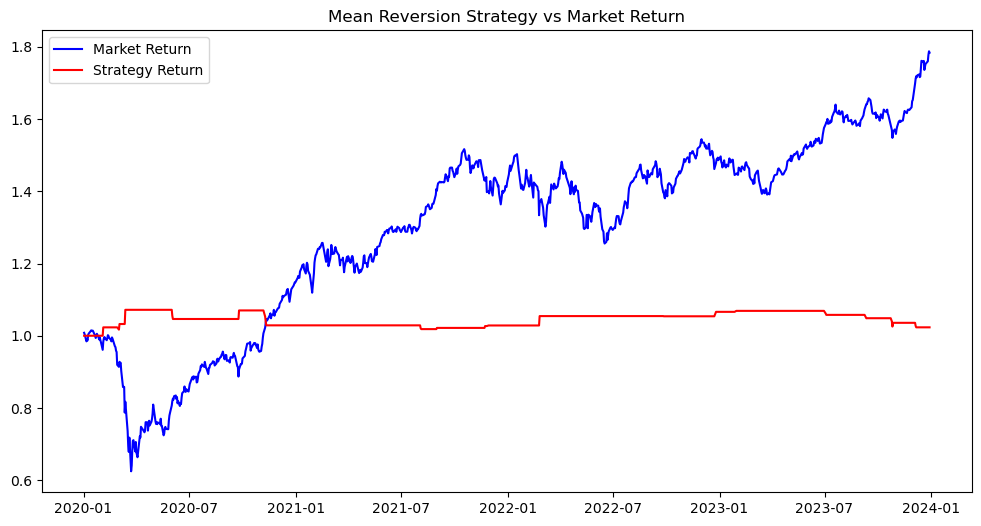

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(nifty_data_n.index, nifty_data_n['Cumulative Market Return'], label='Market Return', color='blue')
plt.plot(nifty_data_n.index, nifty_data_n['Cumulative Strategy Return'], label='Strategy Return', color='red')
plt.legend()
plt.title("Mean Reversion Strategy vs Market Return")
plt.show()


we still see no significant improvement even after incorporating all these steps

## Calculating the new sharpe ratio

In [152]:
risk_free_rate = 0.05  # Assume 5% annual risk-free rate
excess_returns = nifty_data_n['Strategy Return'] - (risk_free_rate / 252)
sharpe_ratio = excess_returns.mean() / excess_returns.std() * (252**0.5)

print("New Sharpe Ratio:", sharpe_ratio)


New Sharpe Ratio: -8.208368900648562


## New Dropdown Score

In [201]:
# Maximum Drawdown Calculation
rolling_max_MR_n = nifty_data_n['Cumulative Strategy Return'].cummax()
drawdown_MR_n = (nifty_data_n['Cumulative Strategy Return'] / rolling_max_MR_n) - 1
max_drawdown_MR_n = drawdown_MR_n.min()
print(f"Max Drawdown: {max_drawdown_MR_n:.2%}")

Max Drawdown: -4.98%


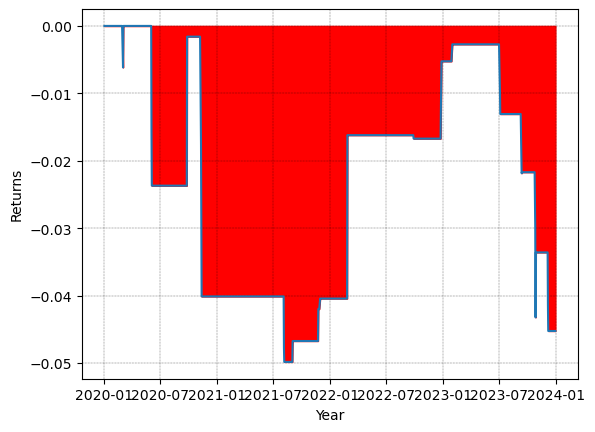

In [203]:
plt.plot(drawdown_MR_n)
plt.ylabel('Returns')
plt.xlabel('Year')
plt.fill_between(drawdown_MR_n.index, drawdown_MR_n, color='red')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)

## Challenges with Mean Reversion Strategy and Shift to Trend-Following Strategy

After incorporating several improvements such as optimizing Bollinger Bands, making them dynamic, adding technical indicators like RSI, implementing the Kelly Criterion for optimal capital allocation, and incorporating ATR-based stop-loss, I backtested the mean reversion strategy again. Despite these enhancements, I observed no significant improvements in the strategy's returns. The negative Sharpe ratio and the high drawdown score confirmed the disappointing performance.

### Possible Reason for Poor Performance:
- **Upward Trend in Nifty50**: The plot revealed that Nifty50 followed a consistent upward trend during the period (2020-2024).
- **Mean Reversion Limitation**: Mean reversion strategies work best in sideways or ranging markets, where prices oscillate around a mean value. Given that the market was trending upwards, the strategy failed to perform optimally.

### Conclusion:
Realizing the limitations of the mean reversion strategy in a trending market, I decided to shift towards a **trend-following strategy**. For this, I chose the **EMA Crossover strategy**, which is designed to capture trends in the market more effectively.


# EMA Crossover Strategy

[*********************100%***********************]  1 of 1 completed
C:\Users\captr\AppData\Local\Temp\ipykernel_5516\2400790560.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][short_window:] = np.where(df['EMA_10'][short_window:] > df['EMA_50'][short_window:], 1, -1)


Index(['Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI'], dtype='object')


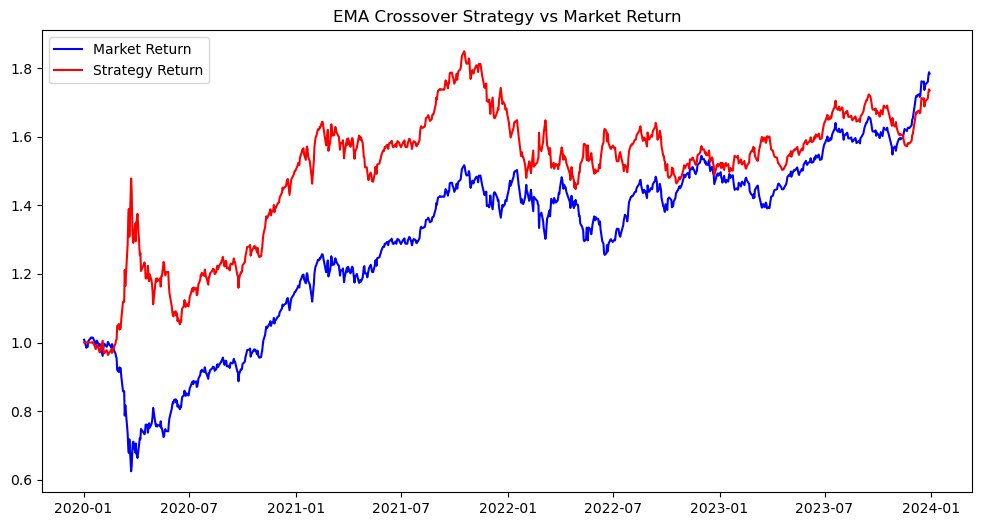

In [209]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Nifty50 data from Yahoo Finance
df = yf.download("^NSEI", start="2020-01-01", end="2024-01-01")

# Flatten MultiIndex columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns]

# Check the column names to make sure they are correctly formatted
print(df.columns)

# Define the short and long windows for the EMAs
short_window = 10   # Short-term EMA
long_window = 50   # Long-term EMA

# Calculate the Exponential Moving Averages (EMAs)
# Use the appropriate column based on your column structure
df["EMA_10"] = df['Close_^NSEI'].ewm(span=short_window, adjust=False).mean()
df["EMA_50"] = df['Close_^NSEI'].ewm(span=long_window, adjust=False).mean()

# Generate Buy/Sell signals: Buy when EMA_50 crosses above EMA_200 and Sell when EMA_50 crosses below EMA_200
df['Signal'] = 0
df['Signal'][short_window:] = np.where(df['EMA_10'][short_window:] > df['EMA_50'][short_window:], 1, -1)

# Cumulative strategy returns: Apply strategy (1 for buy, -1 for sell)
df['Strategy Return'] = df['Signal'].shift(1) * df['Close_^NSEI'].pct_change()

# Calculate Cumulative Strategy Return
df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()

# Calculate Cumulative Market Return
df['Market Return'] = df['Close_^NSEI'].pct_change()
df['Cumulative Market Return'] = (1 + df['Market Return']).cumprod()

# Plot the strategy vs market return
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative Market Return'], label='Market Return', color='blue')
plt.plot(df.index, df['Cumulative Strategy Return'], label='Strategy Return', color='red')
plt.legend()
plt.title("EMA Crossover Strategy vs Market Return")
plt.show()


## Outperformance of the Strategy with EMA Crossover

Upon applying the **EMA Crossover** strategy, it is immediately clear that our strategy has successfully outperformed the market returns.

### Mathematical Explanation for the Outperformance

The outperformance can be attributed to the fact that the **EMA Crossover strategy** effectively capitalizes on trends in the market. The strategy generates buy signals when the short-term **EMA** (e.g., 10-period) crosses above the long-term **EMA** (e.g., 50-period), and sell signals when the short-term **EMA** crosses below the long-term **EMA**.

Mathematically, the strategy can be explained as follows:

- **Buy Signal**: When the short-term EMA (e.g., 10-period) is greater than the long-term EMA (e.g., 50-period).
- **Sell Signal**: When the short-term EMA (e.g., 10-period) is less than the long-term EMA (e.g., 50-period).

The strategy returns are calculated using the following formula:

- **Strategy Return** at time t:  
  `Strategy Return_t = Signal_(t-1) * (Price_t - Price_(t-1)) / Price_(t-1)`
  - Where:
    - `Signal_(t-1)` is the trading signal (either 1 for buy, -1 for sell, or 0 for no trade).
    - `Price_t` is the asset price at time t.
    - `Price_(t-1)` is the asset price at time (t-1).

The **Cumulative Strategy Return** is then calculated as:

- `Cumulative Strategy Return = Product of (1 + Strategy Return_t) for all t from 1 to T`

This approach ensures that the strategy follows the market's trend direction, resulting in superior returns when the market is trending up.


In [164]:
df.columns

Index(['Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI',
       'EMA_50', 'EMA_200', 'Signal', 'Strategy Return',
       'Cumulative Strategy Return', 'Market Return',
       'Cumulative Market Return'],
      dtype='object')

## Sharpe Ratio Calculation

In [186]:
# Sharpe Ratio Calculation
sharpe_ratio_EMA = (df['Strategy Return'].mean() / df['Strategy Return'].std()) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 1.49


Better Risk Adjusted Return for 1 unit of risk we are getting almost 1.5x return

## Maximum Drawdown

In [197]:
# Maximum Drawdown Calculation
rolling_max_EMA = df['Cumulative Strategy Return'].cummax()
drawdown_EMA = (df['Cumulative Strategy Return'] / rolling_max_EMA) - 1
max_drawdown_EMA = drawdown_EMA.min()
print(f"Max Drawdown: {max_drawdown_EMA:.2%}")


Max Drawdown: -28.76%


This suggest at some point the index lost almost 29% of its value

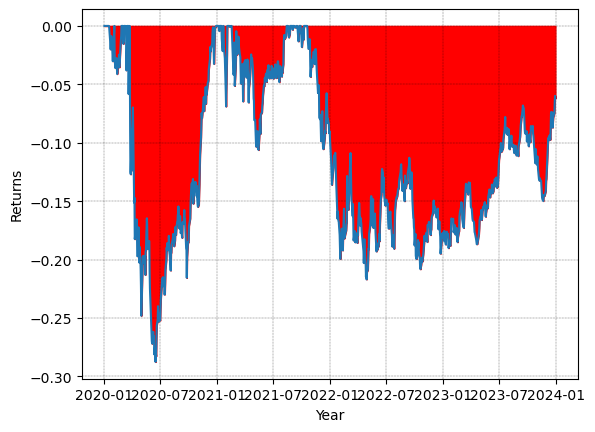

In [198]:
plt.plot(drawdown_EMA)
plt.ylabel('Returns')
plt.xlabel('Year')
plt.fill_between(drawdown_EMA.index, drawdown_EMA, color='red')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)

# Introducing 10% Stop-Loss to automate entry-exit position

[*********************100%***********************]  1 of 1 completed


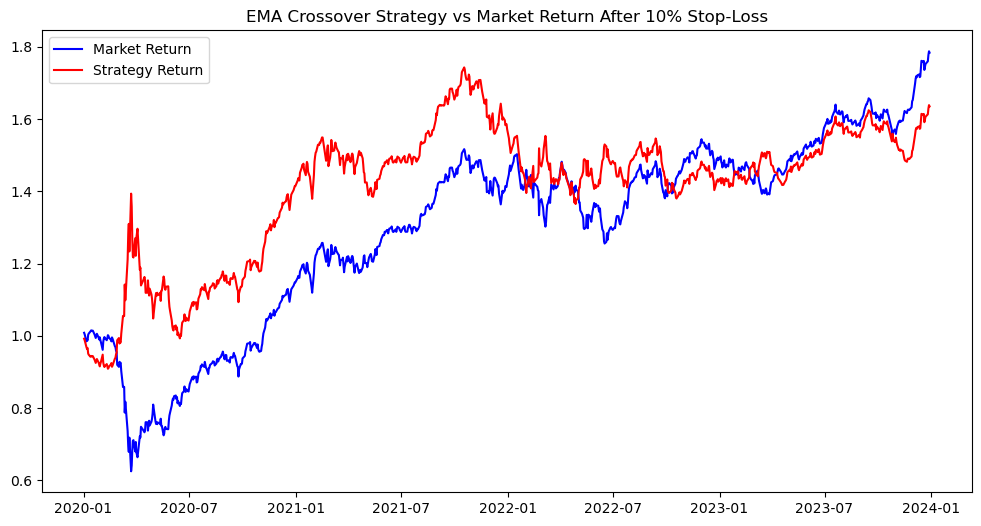

In [181]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Nifty50 data
df2 = yf.download("^NSEI", start="2020-01-01", end="2024-01-01")
# Flatten MultiIndex columns if present
if isinstance(df2.columns, pd.MultiIndex):
    df2.columns = ['_'.join(col).strip() for col in df2.columns]

# Define EMA short and long windows
short_window = 10  
long_window = 50  

# Calculate EMAs
df2["EMA_50"] = df2['Close_^NSEI'].ewm(span=short_window, adjust=False).mean()
df2["EMA_200"] = df2['Close_^NSEI'].ewm(span=long_window, adjust=False).mean()

# Generate Buy/Sell signals based on EMA crossover
df2['Signal'] = np.where(df2["EMA_50"] > df2["EMA_200"], 1, -1)

# Define Stop-Loss %
stop_loss_pct = 0.10  # 10% stop-loss

# Calculate Stop-Loss levels
df2['Stop_Loss'] = df2['Close_^NSEI'] * (1 - stop_loss_pct)  # Stop-loss for long positions
df2['Stop_Hit'] = np.where(df2['Close_^NSEI'] < df2['Stop_Loss'], -1, 0)  # Stop-loss trigger

# Modify signal to exit trade when stop-loss is hit
df2['Final_Signal'] = np.where(df2['Stop_Hit'] == -1, 0, df2['Signal'])

# Calculate Strategy Returns with Stop-Loss
df2['Strategy Return'] = df2['Final_Signal'].shift(1) * df2['Close_^NSEI'].pct_change()

# Calculate Cumulative Returns
df2['Cumulative Strategy Return'] = (1 + df2['Strategy Return']).cumprod()
df2['Market Return'] = df2['Close_^NSEI'].pct_change()
df2['Cumulative Market Return'] = (1 + df2['Market Return']).cumprod()

# Plot Strategy vs Market Return
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2['Cumulative Market Return'], label='Market Return', color='blue')
plt.plot(df2.index, df2['Cumulative Strategy Return'], label='Strategy Return', color='red')
plt.legend()
plt.title("EMA Crossover Strategy vs Market Return After 10% Stop-Loss")
plt.show()


## Strategy Performance vs Market Return

Here, we can see that our strategy is providing tough competition to the market return, with the performance being nearly neck-and-neck. However, there's still room for improvement.

### Refining the Strategy with Flexible Stop-Loss

One potential improvement could be to loosen the constraints on the stop-loss mechanism. By being more flexible with the stop-loss, we may allow the strategy to ride out short-term market fluctuations, rather than triggering unnecessary exits. This could help the strategy capture more of the long-term trend, which would likely improve overall performance.

Adjusting the stop-loss to be less strict could provide more opportunities for the strategy to take advantage of upward momentum in the market, further enhancing returns.


In [169]:
df2.columns

MultiIndex([( 'Close', '^NSEI'),
            (  'High', '^NSEI'),
            (   'Low', '^NSEI'),
            (  'Open', '^NSEI'),
            ('Volume', '^NSEI')],
           names=['Price', 'Ticker'])

In [184]:
# Sharpe Ratio Calculation
sharpe_ratio_10_SL = (df2['Strategy Return'].mean() / df2['Strategy Return'].std()) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 1.49


In [190]:
# Maximum Drawdown Calculation
rolling_max_10_SL = df2['Cumulative Strategy Return'].cummax()
drawdown_10_SL = (df2['Cumulative Strategy Return'] / rolling_max_10_SL) - 1
max_drawdown_10_SL = drawdown_10_SL.min()
print(f"Max Drawdown: {max_drawdown_10_SL:.2%}")


Max Drawdown: -28.76%


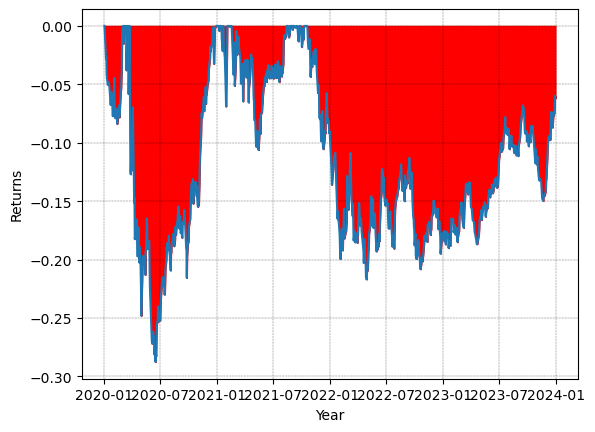

In [195]:
plt.plot(drawdown_10_SL)
plt.ylabel('Returns')
plt.xlabel('Year')
plt.fill_between(drawdown_10_SL.index, drawdown_10_SL, color='red')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)

## Introducing ATR (Average True Rate) based approach to dynamically adjust the stop loss

[*********************100%***********************]  1 of 1 completed


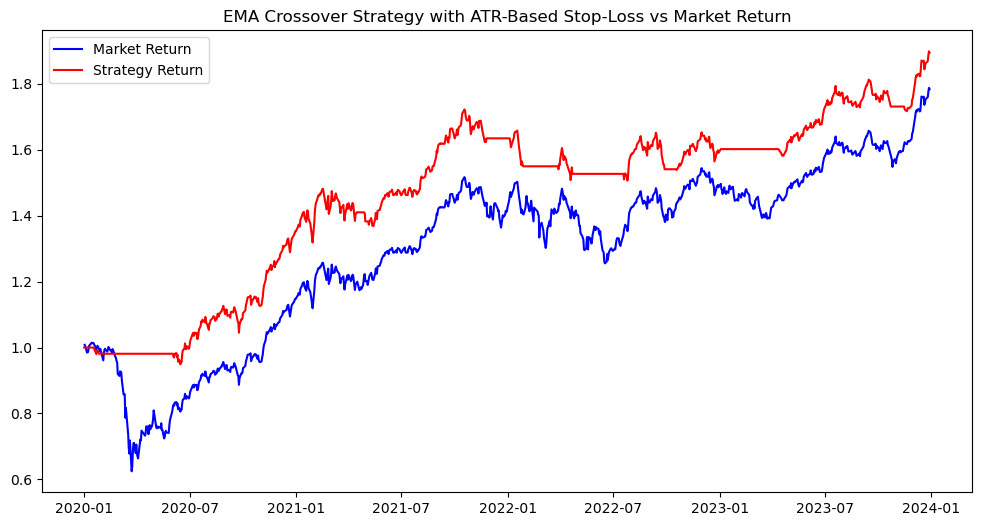

In [179]:
#ATR (Avg True Rate) Based Dynamic Stop-Loss

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Nifty50 data from Yahoo Finance
df3 = yf.download("^NSEI", start="2020-01-01", end="2024-01-01")

if isinstance(df3.columns, pd.MultiIndex):
    df3.columns = ['_'.join(col).strip() for col in df3.columns]

# Calculate ATR (Average True Range)
df3['High-Low'] = df3['High_^NSEI'] - df['Low_^NSEI']
df3['High-Close'] = abs(df3['High_^NSEI'] - df3['Close_^NSEI'].shift(1))
df3['Low-Close'] = abs(df3['Low_^NSEI'] - df3['Close_^NSEI'].shift(1))
# Correct column names to calculate the True Range
df3['True Range'] = df3[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

# Calculate the ATR (14-day rolling average of True Range)
df3['ATR'] = df3['True Range'].rolling(window=14).mean()

# Proceed with your strategy logic


# Define short and long EMAs
short_window = 10
long_window = 50
df3["EMA_50"] = df3['Close_^NSEI'].ewm(span=short_window, adjust=False).mean()
df3["EMA_200"] = df3['Close_^NSEI'].ewm(span=long_window, adjust=False).mean()

# Generate Buy/Sell signals
df3['Signal'] = 0
df3.loc[(df3["EMA_50"] > df3["EMA_200"]), "Signal"] = 1   # Buy signal
df3.loc[(df3["EMA_50"] < df3["EMA_200"]), "Signal"] = -1  # Sell signal

# ATR Stop-Loss Multiplier (adjustable)
atr_multiplier = 2  

# Calculate ATR-Based Stop-Loss
df3['Stop-Loss'] = np.nan
df3.loc[df3['Signal'] == 1, 'Stop-Loss'] = df3['Close_^NSEI'] - (df3['ATR'] * atr_multiplier)  # Long stop-loss
df3.loc[df3['Signal'] == -1, 'Stop-Loss'] = df3['Close_^NSEI'] + (df3['ATR'] * atr_multiplier)  # Short stop-loss

# Strategy Returns with Stop-Loss
df3['Strategy Return'] = np.where(df3['Close_^NSEI'] > df3['Stop-Loss'], df3['Signal'].shift(1) * df3['Close_^NSEI'].pct_change(), 0)

# Calculate Cumulative Returns
df3['Cumulative Strategy Return'] = (1 + df3['Strategy Return']).cumprod()
df3['Market Return'] = df3['Close_^NSEI'].pct_change()
df3['Cumulative Market Return'] = (1 + df3['Market Return']).cumprod()

# Plot Strategy vs Market Return
plt.figure(figsize=(12, 6))
plt.plot(df3.index, df3['Cumulative Market Return'], label='Market Return', color='blue')
plt.plot(df3.index, df3['Cumulative Strategy Return'], label='Strategy Return', color='red')
plt.legend()
plt.title("EMA Crossover Strategy with ATR-Based Stop-Loss vs Market Return")
plt.show()


## Strategy Performance After Introducing ATR-Based Dynamic Stop-Loss

The performance of our strategy has significantly improved after incorporating the ATR-based dynamic stop-loss. Our strategy now clearly beats the market returns by a relatively good margin.

### Reason for Improvement

The ATR-based stop-loss allows for dynamic adjustments, taking into account the volatility of the market. This flexibility enables the strategy to avoid being prematurely stopped out during periods of normal market fluctuations, thus allowing it to capture more gains during upward trends. This is why we observe a substantial improvement in performance, with our strategy outperforming the market by a noticeable margin.


In [178]:
df3.columns

Index(['Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI',
       'High-Low', 'High-Close', 'Low-Close'],
      dtype='object')

## Sharpe Ratio for ATR based approach

In [185]:
# Sharpe Ratio Calculation
sharpe_ratio_ATS = (df3['Strategy Return'].mean() / df3['Strategy Return'].std()) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: 1.49


## Maximum Drawdown Score for ATR based approach 

In [189]:
# Maximum Drawdown Calculation
rolling_max_ATS = df3['Cumulative Strategy Return'].cummax()
drawdown_ATS = (df3['Cumulative Strategy Return'] / rolling_max_ATS) - 1
max_drawdown_ATS = drawdown_ATS.min()
print(f"Max Drawdown: {max_drawdown_ATS:.2%}")


Max Drawdown: -12.52%


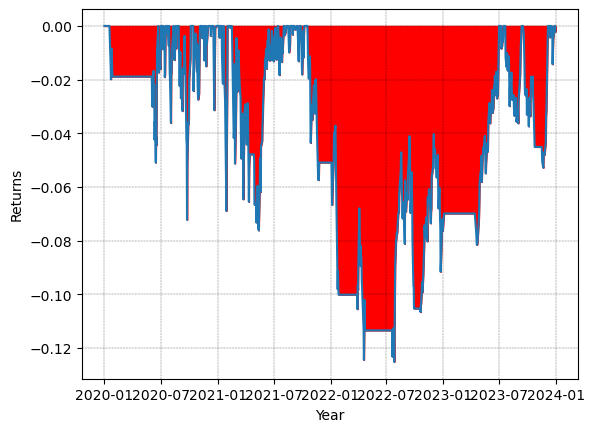

In [194]:
plt.plot(drawdown_ATS)
plt.ylabel('Returns')
plt.xlabel('Year')
plt.fill_between(drawdown_ATS.index, drawdown_ATS, color='red')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)

## Conclusion

Upon introducing the ATR-based dynamic stop-loss, our strategy was significantly able to outperform the market, achieving better risk-adjusted returns. The Sharpe ratio of 1.49 indicates that for every unit of risk, the strategy yields a favorable return, while the Maximum Drawdown (MDD) of -12% shows that the risk exposure was well managed during periods of volatility.

### Additional Inferences:

- **Better Risk Management:** The ATR-based stop-loss dynamically adjusts based on market volatility, offering a more flexible and effective risk management approach compared to static stop-loss levels. This helps in protecting the strategy during market downturns while allowing it to capture gains during favorable trends.

- **Strategy Alignment with Market Conditions:** The positive performance improvement suggests that the strategy is well-suited for trending market conditions. When the market moves in a clear direction, the EMA crossover and ATR-based adjustments work well to maximize returns, which were not as evident when using a mean reversion strategy.

- **Improved Consistency:** The introduction of dynamic risk management has made the strategy more consistent over time, minimizing extreme drawdowns while enhancing overall returns. This results in a more stable equity curve compared to previous iterations.

In summary, the combination of technical indicators, dynamic stop-loss adjustments, and trend-following strategy has led to a more robust trading approach, which is not only outperforming the market but also providing a safer risk profile.
